In [129]:
import pandas as pd
import numpy as np
import pymongo as pm
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
import copy

In [170]:
client = pm.MongoClient()
bm = pd.DataFrame(client["Fields"]["股價淨值比"].find({"日期": {"$gte": datetime.datetime(2004, 1, 1)}}, {"_id": 0})).set_index("日期")
cl = pd.DataFrame(client["Fields"]["還原收盤價"].find({"日期": {"$gte": datetime.datetime(2004, 1, 1)}}, {"_id": 0})).set_index("日期")
bm = bm.reindex(sorted(bm.columns), axis=1)
cl = cl.reindex(sorted(cl.columns), axis=1)

In [171]:
bm_m = bm.resample("M").last()
cl_m = cl.resample("M").last()
bm_m = bm_m.subtract(bm_m.mean(axis=1), axis=0).divide(bm_m.std(axis=1), axis=0)
bm_m = bm_m.clip(-5, 5)

<AxesSubplot: >

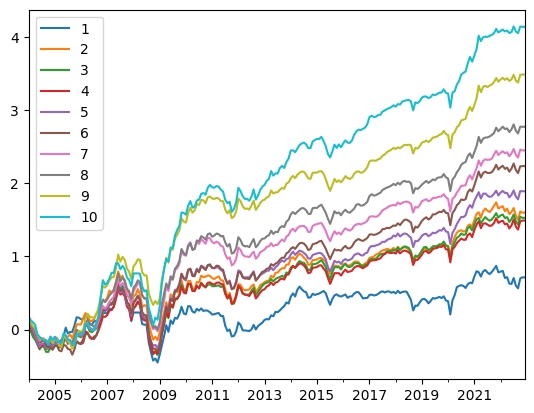

In [201]:
labels = list(range(10, 0, -1))
#labels = list(range(1, 11))
rt = pd.DataFrame()
for i, r in bm_m.iterrows():
    se = cl_m.pct_change().shift(-1).loc[i]
    rt = pd.concat([rt, se.groupby(pd.qcut(r, q=10, labels=labels)).mean()], axis=1)
rt = rt.T.reindex(sorted(rt.T.columns), axis=1)
rt.fillna(0).cumsum().plot()

虛無假設為因子收益率=0，T值不滿足下列條件則無法拒絕虛無假設
因子的T值須>2，嚴格要求的話要>3.8，此時T值為 4.58
秩相關係數: 0.93


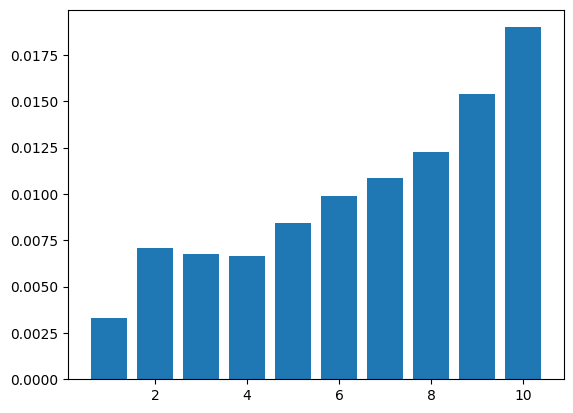

In [204]:
因子收益率 = rt[10].fillna(0) - rt[1].fillna(0)
收益率估計 = 因子收益率.mean()
標準誤 = 因子收益率.std()/np.sqrt(len(因子收益率))
t值 = 收益率估計/標準誤
print("虛無假設為因子收益率=0，T值不滿足下列條件則無法拒絕虛無假設")
print(f"因子的T值須>2，嚴格要求的話要>3.8，此時T值為 {t值:.2f}")

# 秩相關係數
rk = rt.mean(axis=0).corr(pd.Series(list(range(1, 11))), method="spearman")
print(f"秩相關係數: {rk:.2f}")
# 月均收益率
plt.bar(x=range(1, 11), height=rt.mean(axis=0))
plt.show()

In [210]:
stats.ttest_ind(rt.mean(axis=0).values, list(range(1, 11)))

Ttest_indResult(statistic=-5.734159285043741, pvalue=1.9513387405132463e-05)

## 雙重排序

In [213]:
bm = pd.DataFrame(client["Fields"]["股價淨值比"].find({"日期": {"$gte": datetime.datetime(2004, 1, 1)}}, {"_id": 0})).set_index("日期")
cl = pd.DataFrame(client["Fields"]["還原收盤價"].find({"日期": {"$gte": datetime.datetime(2004, 1, 1)}}, {"_id": 0})).set_index("日期")
cap = pd.DataFrame(client["Fields"]["總市值(億)"].find({"日期": {"$gte": datetime.datetime(2004, 1, 1)}}, {"_id": 0})).set_index("日期")
bm = bm.reindex(sorted(bm.columns), axis=1)
cl = cl.reindex(sorted(cl.columns), axis=1)
cap = cap.reindex(sorted(cap.columns), axis=1)

In [214]:
bm_m = bm.resample("M").last()
cl_m = cl.resample("M").last()
cap_m = cap.resample("M").last()
bm_m = bm_m.subtract(bm_m.mean(axis=1), axis=0).divide(bm_m.std(axis=1), axis=0)
bm_m = bm_m.clip(-5, 5)
cap_m = cap_m.subtract(cap_m.mean(axis=1), axis=0).divide(cap_m.std(axis=1), axis=0)
cap_m = cap_m.clip(-5, 5)


### 分群 重點區
1. 獨立雙重排序
2. 條件雙重排序

#### 1. 獨立雙重排序

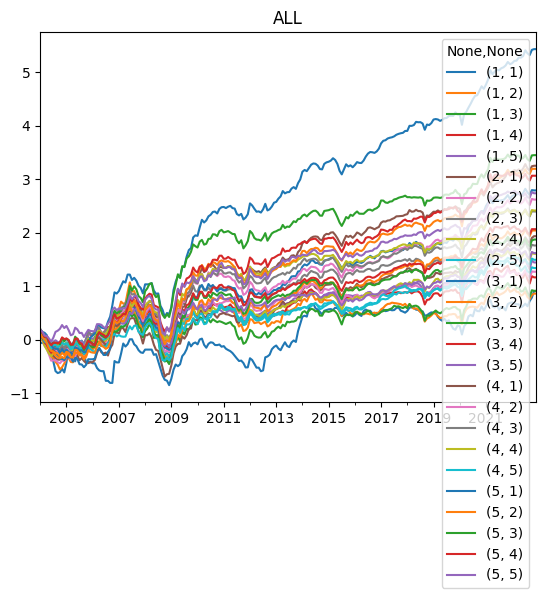

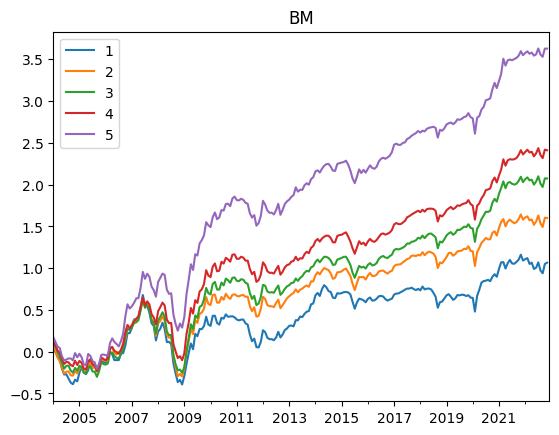

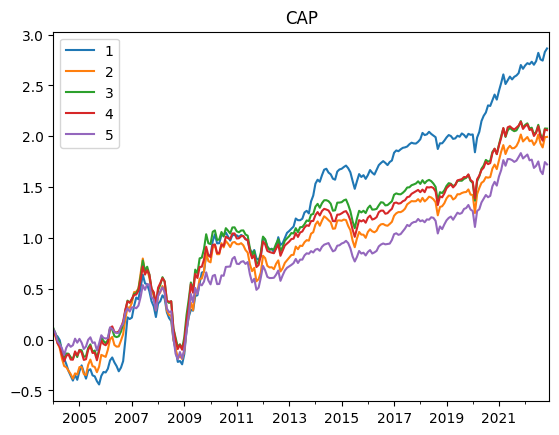

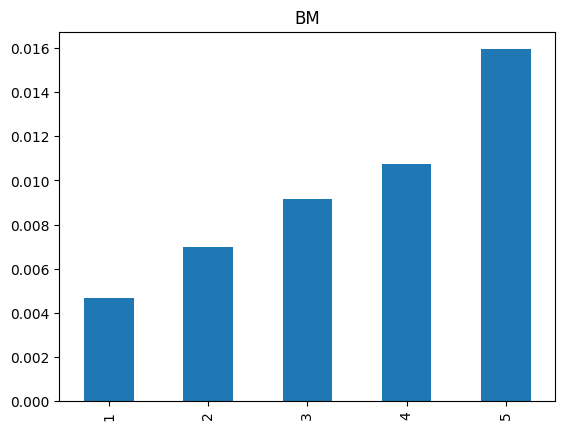

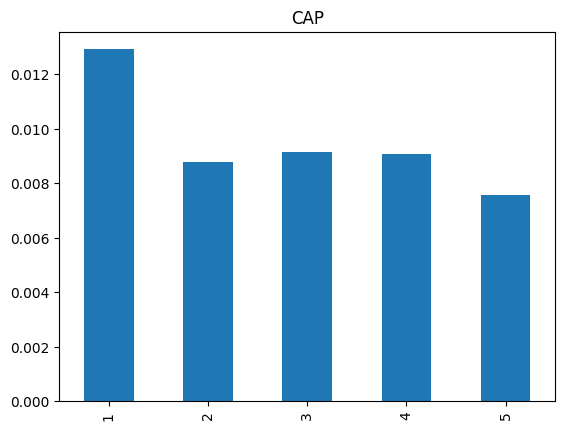

In [423]:
labels_x1 = list(range(5, 0, -1))
labels_x2 = list(range(1, 6, 1))
rt = []
for i, r in bm_m.iterrows():
    R = pd.Series(list(zip(
        pd.qcut(bm_m.loc[i], q=5, labels=labels_x1), # 5代表最便宜
        pd.qcut(cap_m.loc[i], q=5, labels=labels_x2))), # 5代表市值最大
    index=bm_m.columns)
    se = cl_m.pct_change().shift(-1).loc[i]
    rt.append(se.groupby(R).mean())
rt = pd.concat(rt, axis=1)
rt = rt.loc[rt.index.dropna()].T
rt = rt.reindex(sorted(rt.columns), axis=1)
rt.fillna(0).cumsum().plot(title="ALL")
plt.show()
# x1: bm效果 1 = 最貴 5 = 最便宜
rt.groupby(level=0, axis=1).mean().cumsum().plot(title="BM")
rt.groupby(level=1, axis=1).mean().cumsum().plot(title="CAP")
plt.show()

# x2: cap效果 1 = 小市值 5 = 大市值
rt.mean(axis=0).groupby(level=0, axis=0).mean().plot.bar(title="BM")
plt.show()
rt.mean(axis=0).groupby(level=1, axis=0).mean().plot.bar(title="CAP")
plt.show()

#### 條件雙重排序

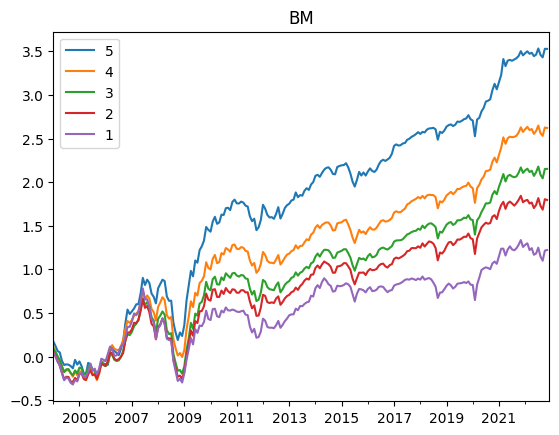

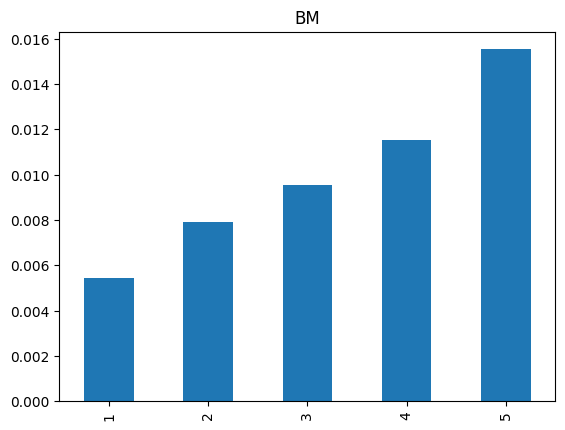

收益率估計: 0.010160194221662824


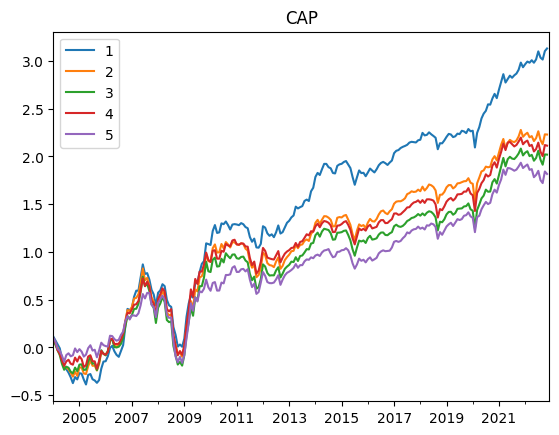

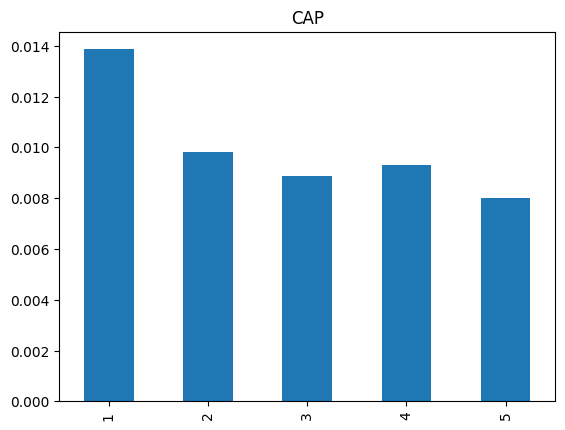

收益率估計: 0.0057854801687657114


In [451]:
labels_x1 = list(range(5, 0, -1))
labels_x2 = list(range(1, 6, 1))

def second_group(s, i, m, l):
    # 每次資料丟進來都是優先分完一次的資料，將資料再次分群，靠的是.loc[i, s.index]，這邊s.index使這次分群只在分過一次的商品內
    se = s.groupby(pd.qcut(m.loc[i, s.index], q=5, labels=l)).mean()
    return se
##  X1 BM
rt = []
for i, r in bm_m.iterrows():
    se = cl_m.pct_change().shift(-1).loc[i]
    rt.append(se.groupby(pd.qcut(cap_m.loc[i], q=5, labels=labels_x2)).apply(second_group, i=i, m=bm_m, l=labels_x1))
rt = pd.concat(rt, axis=1)
rt = rt.loc[rt.index.dropna()].T
rt = rt.reindex(sorted(rt.columns), axis=1)
# x1: bm效果 1 = 最貴 5 = 最便宜
估計收益率 = (rt.groupby(level=1, axis=1).mean()[5] -rt.groupby(level=1, axis=1).mean()[1]).mean()
rt.groupby(level=1, axis=1).mean().cumsum().plot(title="BM")
plt.show()
rt.mean(axis=0).groupby(level=1, axis=0).mean().sort_index(ascending=False).plot.bar(title="BM")
plt.show()
print(f"收益率估計: {估計收益率}")
## X2 CAP
rt = []
for i, r in bm_m.iterrows():
    se = cl_m.pct_change().shift(-1).loc[i]
    rt.append(se.groupby(pd.qcut(bm_m.loc[i], q=5, labels=labels_x1)).apply(second_group, i=i, m=cap_m, l=labels_x2))
rt = pd.concat(rt, axis=1)
rt = rt.loc[rt.index.dropna()].T
rt = rt.reindex(sorted(rt.columns), axis=1)
# x2: cap效果 1 = 小市值 5 = 大市值
估計收益率 = (rt.groupby(level=1, axis=1).mean()[1] -rt.groupby(level=1, axis=1).mean()[5]).mean()
rt.groupby(level=1, axis=1).mean().cumsum().plot(title="CAP")
plt.show()
rt.mean(axis=0).groupby(level=1, axis=0).mean().sort_index(ascending=True).plot.bar(title="CAP")
plt.show()
print(f"收益率估計: {估計收益率}")



In [461]:
print(f"時序因子收益率 {chr(955)}t")
rt.groupby(level=1, axis=1).mean()[1] - rt.groupby(level=1, axis=1).mean()[5]

時序因子收益率 λt


2004-01-31    0.013095
2004-02-29   -0.000872
2004-03-31    0.032700
2004-04-30   -0.017919
2004-05-31   -0.058063
                ...   
2022-08-31    0.031481
2022-09-30    0.011099
2022-10-31   -0.033094
2022-11-30    0.053406
2022-12-31         NaN
Length: 228, dtype: float64

In [ ]:
rt.groupby(level=1, axis=1).mean()[1] - rt.groupby(level=1, axis=1).mean()[5]